# Regressão Logística usando Softmax no Keras - Iris dataset

Este notebook procura reproduzir o exemplo de Regressão Logística usando Softmax,
já feito utilizando programação matricial. 
Neste notebook utiliza-se o Keras, utilizando o mesmo modelo e mesmos parâmetros

In [33]:
%matplotlib inline
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
os.environ['THEANO_FLAGS'] = "device=gpu0,floatX=float32"
from keras.callbacks import Callback
from IPython import display



## Carregando os dados
O dataset Iris está disponível no sklearn.

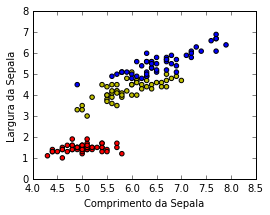

In [39]:
from sklearn import datasets

# Carregando os dados
iris = datasets.load_iris()
X = iris.data[:, ::2]  # usamos apenas 2 features para visualizar em 2D
Y = iris.target

plt.figure(1, figsize=(4, 3))
colors = np.array(['r','y','b'])
plt.scatter(X[:, 0], X[:, 1], c=colors[Y])
plt.xlabel('Comprimento da Sepala')
plt.ylabel('Largura da Sepala')
plt.show()

## Conversão dos rótulos para o formato one-hot encoding

In [40]:
from keras.utils import np_utils 
Y_oh = np_utils.to_categorical(Y, 3) 
print Y[0:5]
print Y_oh[0:5]

[0 0 0 0 0]
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]


## Callback para visualização dinâmica

In [41]:
class BoundaryPlotter(Callback):
    def __init__(self,X,Y,n_epoch, filepath=None,h = .01):
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        
        
    def on_epoch_end(self,epoch, logs={}):
        if 'loss' in logs.keys() and 'val_loss' in logs.keys():
            self.loss_hist.append(logs['loss'])
            self.val_loss_hist.append(logs['val_loss'])
            if epoch%100==0: 
                plt.subplot(121)
                plt.plot(np.arange(epoch+1),self.loss_hist,'b',linewidth = 2.0)
                plt.plot(np.arange(epoch+1),self.val_loss_hist,'r',linewidth = 2.0)
                plt.legend(fontsize=28)
                plt.subplot(122)
                Z = self.model.predict_classes(np.c_[self.xx.ravel(), self.yy.ravel()],verbose=0 )
                # Put the result into a color plot
                Z = Z.reshape(self.xx.shape)
                plt.figure(1, figsize=(4, 3))
                plt.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.coolwarm)
                aux = self.Y == 0
                plt.scatter(self.X[aux, 0], self.X[aux, 1],s=150,c = 'black',marker = 'x')
                aux = self.Y == 1
                plt.scatter(self.X[aux, 0], self.X[aux, 1],s=150,c = 'black',marker = '^')
                aux = self.Y == 2
                plt.scatter(self.X[aux, 0], self.X[aux, 1],s=150,c = 'black',marker = 'o')
                
                display.display(plt.gcf())
                display.clear_output(wait=True)
                #time.sleep(.01)
                

## Definindo a rede neural com o Keras

In [66]:
from keras.models import Sequential 
from keras.layers import Dense, Activation 

nb_classes = 3 
model = Sequential() 
model.add(Dense(output_dim = nb_classes, input_dim=2, weights = [np.zeros((2,3)),np.zeros(3)],activation='softmax')) 

# Parâmetros de treinamento
batch_size = 150
nb_epoch = 10000

## Treinando a rede neural

Excelente blog sobre otimização:

http://sebastianruder.com/optimizing-gradient-descent/


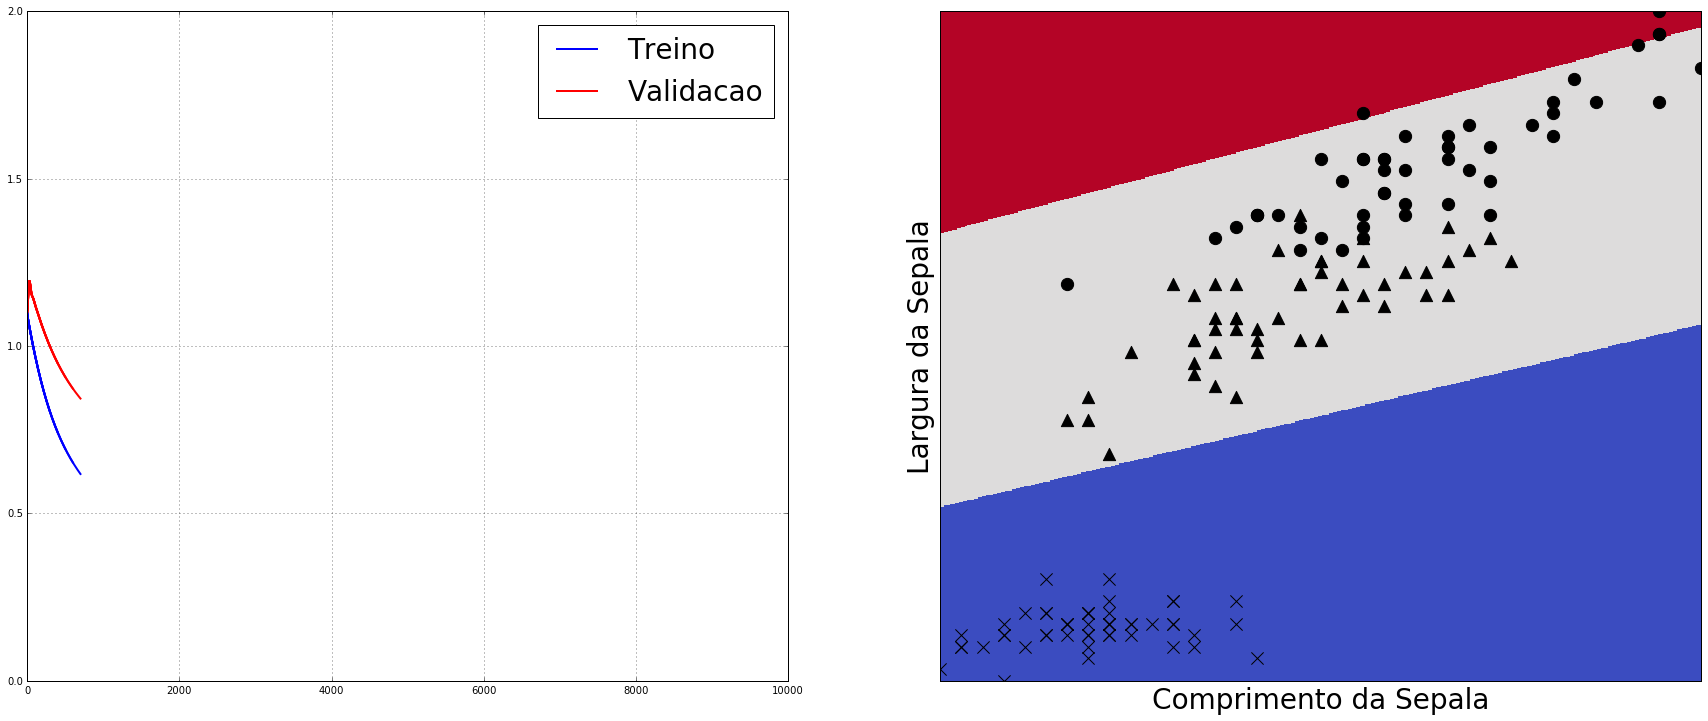

In [ ]:
#Definindo o callback
boundary_plot = BoundaryPlotter(X,Y,nb_epoch)

#Gráficos a serem mostrados pelo callback
ploss = 2.0
fig = plt.figure(figsize=(30,12))
plt.subplot(121)
plt.plot(0.0,ploss)
plt.ylim(0.0, ploss)
plt.xlim(0, nb_epoch)
plt.plot(-1,-1,'b',linewidth = 2.0,label = "Treino")
plt.plot(-1,-1,'r',linewidth = 2.0,label = "Validacao")
plt.legend()
plt.grid(True)
plt.subplot(122)
plt.xlim(X[:,0].min(), X[:,0].max())
plt.ylim(X[:,1].min(), X[:,1].max())
plt.xlabel('Comprimento da Sepala',fontsize=28)
plt.ylabel('Largura da Sepala',fontsize=28)
plt.xticks(())
plt.yticks(())
                
model.compile(optimizer='adam', loss='categorical_crossentropy') 
history = model.fit(X, Y_oh, batch_size=batch_size, nb_epoch=nb_epoch,verbose=0,validation_split=0.1,callbacks = [boundary_plot])
